# Improving  Academic Outcome For Secondary Education in Nigeria -- DataFestAfrica Hackathon 2024


## Model development

The task here involves creating a forecasting model that can adequately inform the stakeholders at GMS of the likelihood of a student passing or failing their upcoming exams. In this scenario, the upcoming exams refer to their mock exams written to prepare students for their JAMB and WASSCE exams. At GMS, if a student can do well in the mock exams, then they can do well in the JAMB and WASSCE exams. Furthermore, GMS is concerned about other factors that can affect a student's upcoming results aside from their previous exam scores in class.

### Solution

The optimized model built is divided into two for art and for science students. 

## Importing required libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [6]:
#installing the necessary library for the postgres sql database

#!pip install psycopg2

In [7]:
#connecting to the database
import psycopg2

try:
    conn = psycopg2.connect(
        dbname = 'defaultdb',
        host = 'pg-25522902-datafestdatathon.i.aivencloud.com',
        port = 19878,
        user = 'avnadmin',
        password = 'AVNS_OtYHQvDV60VYLamjgMh',
        sslmode='require'
    )  
    
    #creating a cursor object
    cursor = conn.cursor()
    
    #list of tables to retrieve
    table_names = ['attendance_table', 'class_resources_table','extracurricular_activity', 
                   'parent_table','ss3_student_survey', 'staff_table','student_performance', 
                   'student_table','teachers_table']
    
    dataframes = {}
    
    for table in table_names:
        query = f"SELECT * FROM {table};"
        cursor.execute(query)
        rows = cursor.fetchall()
        col_names = [desc[0] for desc in cursor.description]
        
        df = pd.DataFrame(rows, columns = col_names)
        
        #store the dataframe in the dictionary
        dataframes[table] = df
        
except Exception as error:
    print(f"Error: {error}")
    
finally:
    if 'conn' in locals():
        cursor.close()
        conn.close()

In [8]:
#saving to different dataframes
students = dataframes['student_table']
attendance = dataframes['attendance_table']
class_resources = dataframes['class_resources_table']
extracurricular =dataframes['extracurricular_activity']
parents =dataframes['parent_table']
ss3_students =dataframes['ss3_student_survey']
staffs =dataframes['staff_table']
student_performance = dataframes['student_performance']
teachers =dataframes['teachers_table']

In [9]:
#initial EDA
extracurricular.head()

,student_id,extracurricular_activity,weekly_hours
0,ccf3a17156dc4907ba6c34ab6712303a,Jet club,3
1,310c0c003fa741049bf90e27dc96925e,Sports,4
2,23e2fcb472d8467d894a05e430b187ef,Art,4
3,766ecb15474e4c19aef912766c006f61,Press club,8
4,134c6c92ec5b427c9fde4fbf3ff350bf,Jet club,10


In [10]:
student_performance.head()

,student_id,mathematics,english_language,civic_education,economics,crs_islam,physics,chemistry,biology,geography,computer_science,government,commerce,literature,history,accounting
0,ccf3a17156dc4907ba6c34ab6712303a,3,12,81,43,1,92.0,13.0,79.0,2.0,94.0,NaN,NaN,NaN,NaN,NaN
1,310c0c003fa741049bf90e27dc96925e,0,71,96,30,54,NaN,NaN,NaN,NaN,NaN,46.0,89.0,3.0,35.0,52.0
2,23e2fcb472d8467d894a05e430b187ef,41,0,12,31,74,32.0,37.0,9.0,89.0,72.0,NaN,NaN,NaN,NaN,NaN
3,766ecb15474e4c19aef912766c006f61,80,46,58,59,29,NaN,NaN,NaN,NaN,NaN,10.0,65.0,0.0,56.0,38.0
4,134c6c92ec5b427c9fde4fbf3ff350bf,92,61,62,68,80,97.0,43.0,30.0,40.0,22.0,NaN,NaN,NaN,NaN,NaN


In [11]:
students.head()

,student_id,class_id,first_name,family_name,gender,date_of_birth,state_of_origin,engagement_in_class,health_condition,class_spec
0,ccf3a17156dc4907ba6c34ab6712303a,SS1 Class D,Udo,Chijioke,Male,2008-06-21,Taraba,Unactive,Sickle Cell,Science
1,310c0c003fa741049bf90e27dc96925e,SS1 Class C,Chidiebere,Oni,Female,2008-05-31,Enugu,Troublesome,None,Art
2,23e2fcb472d8467d894a05e430b187ef,SS3 Class F,Alaba,Aminu,Male,2007-09-09,Borno,Active,None,Science
3,766ecb15474e4c19aef912766c006f61,SS1 Class E,Ade,Eniola,Male,2007-03-16,Lagos,Slightly active,None,Art
4,134c6c92ec5b427c9fde4fbf3ff350bf,SS3 Class F,Haruna,Ebuka,Female,2007-07-18,Borno,Unactive,Dyslexia,Science


In [12]:
ss3_students.head()

,student_id,reason_for_performance,access_to_resources,study_hours_per_week,health_issues,teacher_support,parental_support,stress_level,peer_influence,additional_tutoring,use_of_study_groups,exam_anxiety,jamb_scores,num_credit_passes_waec,verdict
0,23e2fcb472d8467d894a05e430b187ef,Confidence issues,Yes,11,Yes,3,3,No,Yes,No,Yes,Yes,138,8,Fail
1,134c6c92ec5b427c9fde4fbf3ff350bf,Lack of preparation,No,22,No,1,5,Yes,No,No,Yes,No,191,7,Fail
2,680ac07a2a934d62bc835dc0d9441fa5,Difficulty understanding topics,Yes,8,Yes,3,2,Yes,Yes,No,Yes,Yes,356,3,Fail
3,63f2ae24fc3d4348808d4127610461e3,Lack of resources,Yes,5,No,5,2,Yes,No,No,No,No,196,5,Fail
4,b253d2186c4a47ea890617f2747b6dba,Lack of resources,No,10,Yes,5,5,No,No,Yes,No,No,268,6,Pass


In [13]:
#merging relevant tables together to get required table

df = pd.merge(ss3_students, student_performance, on='student_id', how='inner')
df = pd.merge(df,students, on='student_id', how='inner')
df = pd.merge(df, extracurricular, on='student_id', how='inner')

#dropping irrelevant columns
df = df.drop(['first_name', 'family_name','gender','date_of_birth','state_of_origin','engagement_in_class','health_condition', 'extracurricular_activity'], axis=1)
df.head()

,student_id,reason_for_performance,access_to_resources,study_hours_per_week,health_issues,teacher_support,parental_support,stress_level,peer_influence,additional_tutoring,...,geography,computer_science,government,commerce,literature,history,accounting,class_id,class_spec,weekly_hours
0,23e2fcb472d8467d894a05e430b187ef,Confidence issues,Yes,11,Yes,3,3,No,Yes,No,...,89.0,72.0,NaN,NaN,NaN,NaN,NaN,SS3 Class F,Science,4
1,134c6c92ec5b427c9fde4fbf3ff350bf,Lack of preparation,No,22,No,1,5,Yes,No,No,...,40.0,22.0,NaN,NaN,NaN,NaN,NaN,SS3 Class F,Science,10
2,680ac07a2a934d62bc835dc0d9441fa5,Difficulty understanding topics,Yes,8,Yes,3,2,Yes,Yes,No,...,66.0,61.0,NaN,NaN,NaN,NaN,NaN,SS3 Class A,Science,8
3,63f2ae24fc3d4348808d4127610461e3,Lack of resources,Yes,5,No,5,2,Yes,No,No,...,86.0,93.0,NaN,NaN,NaN,NaN,NaN,SS3 Class C,Science,1
4,b253d2186c4a47ea890617f2747b6dba,Lack of resources,No,10,Yes,5,5,No,No,Yes,...,79.0,85.0,NaN,NaN,NaN,NaN,NaN,SS3 Class F,Science,7


In [14]:
#renaming the weekly hours column
df = df.rename(columns={'weekly_hours': 'extracurricular_weekly_hours'})
df.columns

Index(['student_id', 'reason_for_performance', 'access_to_resources',
       'study_hours_per_week', 'health_issues', 'teacher_support',
       'parental_support', 'stress_level', 'peer_influence',
       'additional_tutoring', 'use_of_study_groups', 'exam_anxiety',
       'jamb_scores', 'num_credit_passes_waec', 'verdict', 'mathematics',
       'english_language', 'civic_education', 'economics', 'crs_islam',
       'physics', 'chemistry', 'biology', 'geography', 'computer_science',
       'government', 'commerce', 'literature', 'history', 'accounting',
       'class_id', 'class_spec', 'extracurricular_weekly_hours'],
      dtype='object')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   student_id                    338 non-null    object 
 1   reason_for_performance        338 non-null    object 
 2   access_to_resources           338 non-null    object 
 3   study_hours_per_week          338 non-null    int64  
 4   health_issues                 338 non-null    object 
 5   teacher_support               338 non-null    int64  
 6   parental_support              338 non-null    int64  
 7   stress_level                  338 non-null    object 
 8   peer_influence                338 non-null    object 
 9   additional_tutoring           338 non-null    object 
 10  use_of_study_groups           338 non-null    object 
 11  exam_anxiety                  338 non-null    object 
 12  jamb_scores                   338 non-null    int64  
 13  num_c

## Data preparation

In [16]:
#number of students in each subdivision of the SS3 class
student_counts = df.groupby(['class_id', 'class_spec']).size().reset_index(name='student_count')
student_counts

,class_id,class_spec,student_count
0,SS3 Class A,Art,18
1,SS3 Class A,Science,24
2,SS3 Class B,Art,33
3,SS3 Class B,Science,29
4,SS3 Class C,Art,28
5,SS3 Class C,Science,31
6,SS3 Class D,Art,23
7,SS3 Class D,Science,31
8,SS3 Class E,Art,22
9,SS3 Class E,Science,30


The table above shows the distribution of students in the art and science specialization for each class. Folllowing this, the dataframe is divided into two for art and science students in SS3. 

As part of the data preprocessing steps, the ID columns like student_id, class_id and class_spec are removed as they would not lend any relevance during the model training phase.

Furthermore, the GMS management are interested in being able to tell whether a student in the forth coming batch of students would do well in their upcoming exams (consequently their JAMB and WASSCE exams). Hence, to build this model the num_of_credit_passes_waec and jamb_scores features are being removed and the algorithm is trained on the past exam scores and factors that impacted student performance.

In [17]:
#dividing the dataframe into art and science
not_sci_cols = ['accounting', 'history', 'literature', 'commerce', 'government', 'student_id', 'class_id', 'class_spec', 'num_credit_passes_waec', 'jamb_scores']
science_df = df[df['class_spec'] == 'Science']
science_df = science_df.drop(not_sci_cols, axis=1)

not_art_cols = ['computer_science', 'geography', 'biology', 'chemistry', 'physics', 'student_id', 'class_id', 'class_spec', 'num_credit_passes_waec', 'jamb_scores']
art_df = df[df['class_spec'] == 'Art']
art_df = art_df.drop(not_art_cols, axis=1)

In [18]:
#checking for missing values
science_df.isna().sum().sort_values(ascending=False)

reason_for_performance          0
mathematics                     0
computer_science                0
geography                       0
biology                         0
chemistry                       0
physics                         0
crs_islam                       0
economics                       0
civic_education                 0
english_language                0
verdict                         0
access_to_resources             0
exam_anxiety                    0
use_of_study_groups             0
additional_tutoring             0
peer_influence                  0
stress_level                    0
parental_support                0
teacher_support                 0
health_issues                   0
study_hours_per_week            0
extracurricular_weekly_hours    0
dtype: int64

In [19]:
#checking for missing values
art_df.isna().sum().sort_values(ascending=False)

reason_for_performance          0
mathematics                     0
accounting                      0
history                         0
literature                      0
commerce                        0
government                      0
crs_islam                       0
economics                       0
civic_education                 0
english_language                0
verdict                         0
access_to_resources             0
exam_anxiety                    0
use_of_study_groups             0
additional_tutoring             0
peer_influence                  0
stress_level                    0
parental_support                0
teacher_support                 0
health_issues                   0
study_hours_per_week            0
extracurricular_weekly_hours    0
dtype: int64

No null values identified.

## Exploratory Data Analysis (EDA)

In [20]:
science_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178 entries, 0 to 335
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   reason_for_performance        178 non-null    object 
 1   access_to_resources           178 non-null    object 
 2   study_hours_per_week          178 non-null    int64  
 3   health_issues                 178 non-null    object 
 4   teacher_support               178 non-null    int64  
 5   parental_support              178 non-null    int64  
 6   stress_level                  178 non-null    object 
 7   peer_influence                178 non-null    object 
 8   additional_tutoring           178 non-null    object 
 9   use_of_study_groups           178 non-null    object 
 10  exam_anxiety                  178 non-null    object 
 11  verdict                       178 non-null    object 
 12  mathematics                   178 non-null    int64  
 13  english_la

In [21]:
art_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 6 to 337
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   reason_for_performance        160 non-null    object 
 1   access_to_resources           160 non-null    object 
 2   study_hours_per_week          160 non-null    int64  
 3   health_issues                 160 non-null    object 
 4   teacher_support               160 non-null    int64  
 5   parental_support              160 non-null    int64  
 6   stress_level                  160 non-null    object 
 7   peer_influence                160 non-null    object 
 8   additional_tutoring           160 non-null    object 
 9   use_of_study_groups           160 non-null    object 
 10  exam_anxiety                  160 non-null    object 
 11  verdict                       160 non-null    object 
 12  mathematics                   160 non-null    int64  
 13  english_la

In total, for both art and science students we have 22 features where the **verdict** feature is our dependent/target variable and the remaining columns are our explainatory features.

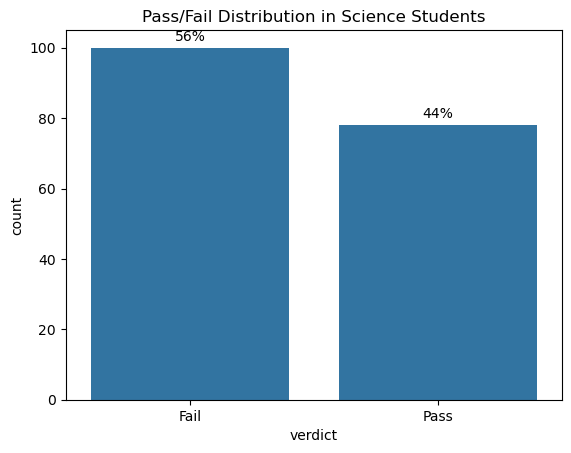

In [22]:
##distribution of our target variable

#create the countplot
ax = sns.countplot(data=science_df, x='verdict')

#calculating percentages
total = len(science_df['verdict'])
for p in ax.patches:
    count = p.get_height()
    percentage = 100 * count / total
    ax.annotate(f'{percentage:.0f}%', (p.get_x() + p.get_width() / 2., count),
                ha = 'center', va = 'baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title('Pass/Fail Distribution in Science Students') 

plt.show()

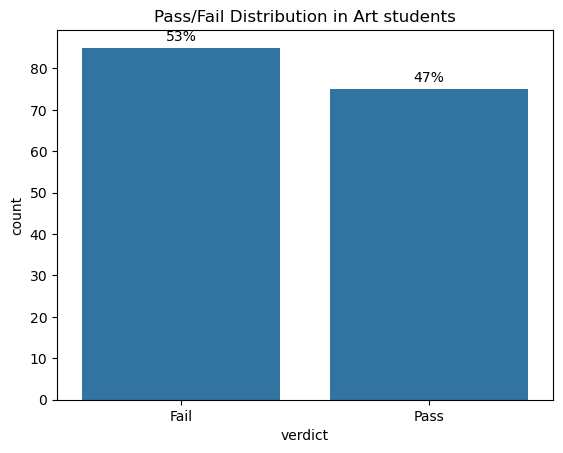

In [23]:
##distribution of our target variable

#create the countplot
ax = sns.countplot(data=art_df, x='verdict')

#calculating percentages
total = len(art_df['verdict'])
for p in ax.patches:
    count = p.get_height()
    percentage = 100 * count / total
    ax.annotate(f'{percentage:.0f}%', (p.get_x() + p.get_width() / 2., count),
                ha = 'center', va = 'baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title('Pass/Fail Distribution in Art students') 

plt.show()

55% of science students in the just concluded academic session underperformed while 45% of them performed above average. The results are also similar for the art students with 58% fail rate and 42% pass rate.

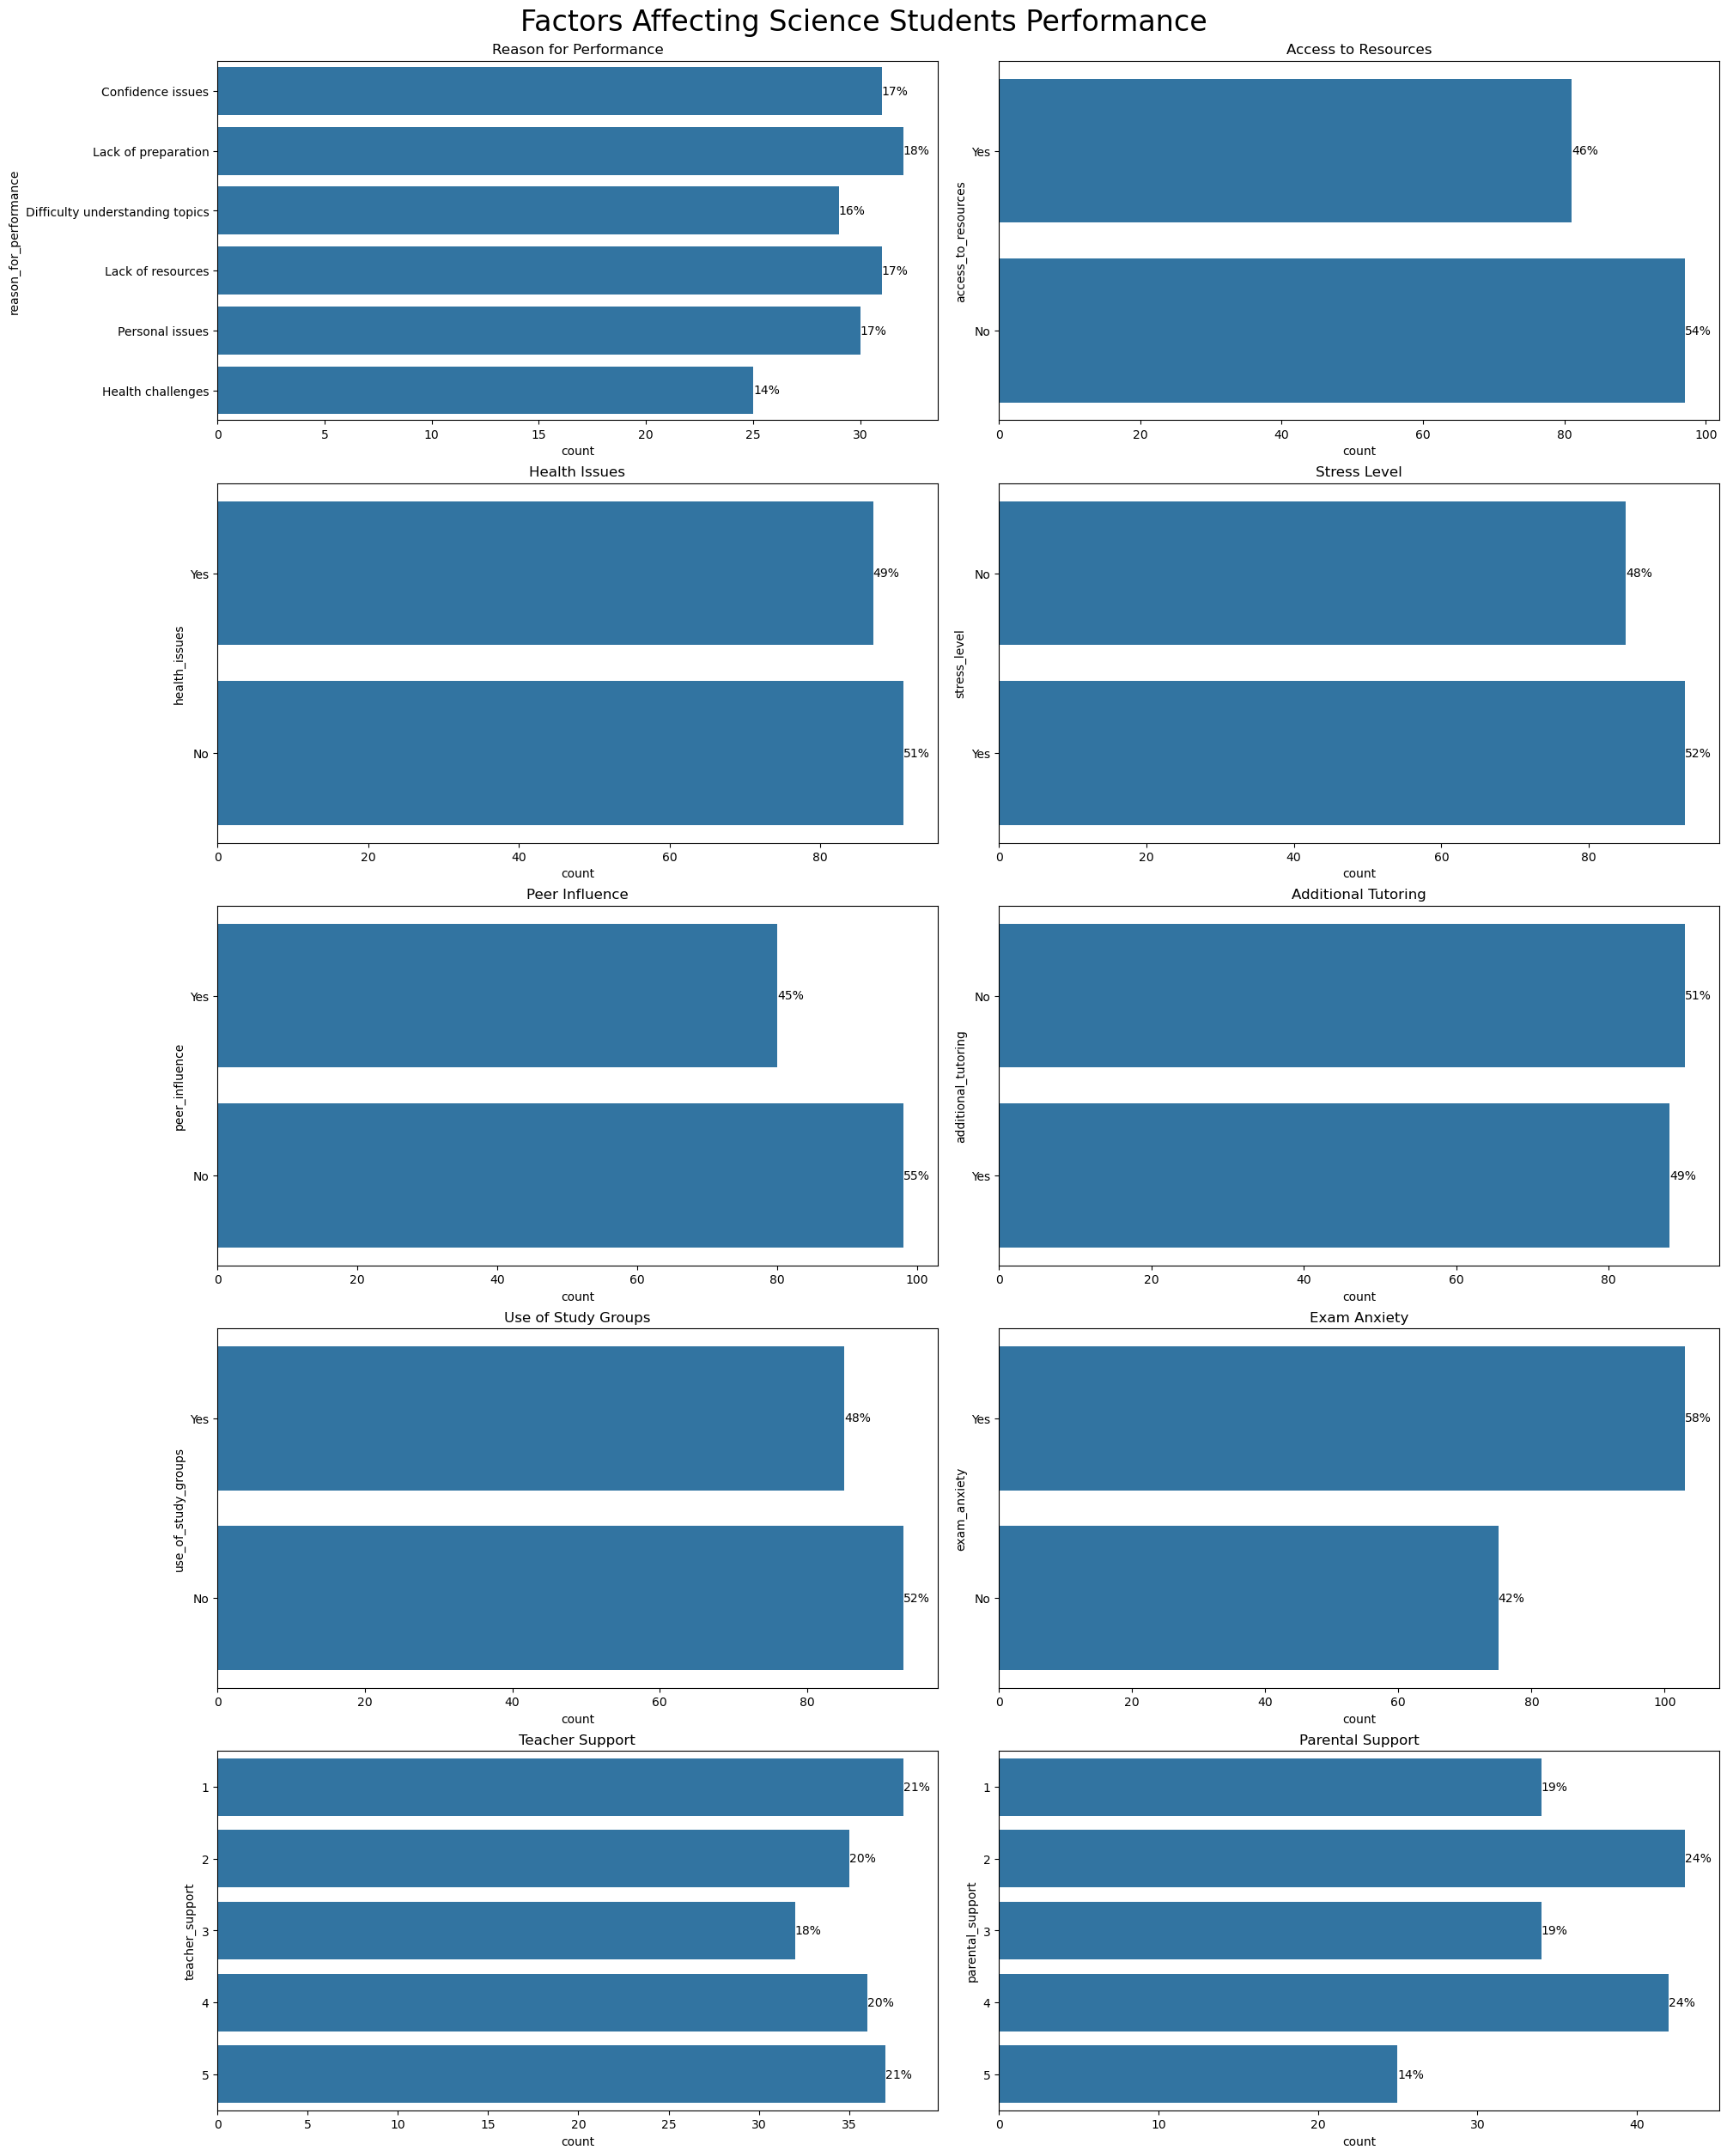

In [25]:
# EDA for factors affecting science student performance
cat_df = science_df[['reason_for_performance', 'access_to_resources', 'health_issues', 'stress_level', 
                     'peer_influence', 'additional_tutoring', 'use_of_study_groups', 'exam_anxiety', 
                     'teacher_support', 'parental_support']]

fig, axs = plt.subplots(5, 2, figsize=(20, 25), layout='constrained')
plt.suptitle('Factors Affecting Science Students Performance', fontsize=24)

# List of titles and corresponding columns
titles = ['Reason for Performance', 'Access to Resources', 'Health Issues', 'Stress Level', 
          'Peer Influence', 'Additional Tutoring', 'Use of Study Groups', 'Exam Anxiety', 
          'Teacher Support', 'Parental Support']

columns = ['reason_for_performance', 'access_to_resources', 'health_issues', 'stress_level', 
           'peer_influence', 'additional_tutoring', 'use_of_study_groups', 'exam_anxiety', 
           'teacher_support', 'parental_support']

# Loop through each subplot
for ax, title, col in zip(axs.flatten(), titles, columns):
    ax.set_title(title)
    sns.countplot(data=cat_df, y=col, ax=ax)

    # Calculate percentages
    total_count = cat_df[col].value_counts()
    for p in ax.patches:
        count = p.get_width()
        percentage = 100 * count / total_count.sum()
        ax.annotate(f'{percentage:.0f}%', (count, p.get_y() + p.get_height() / 2),
                    ha='left', va='center', fontsize=10, color='black')

plt.show()

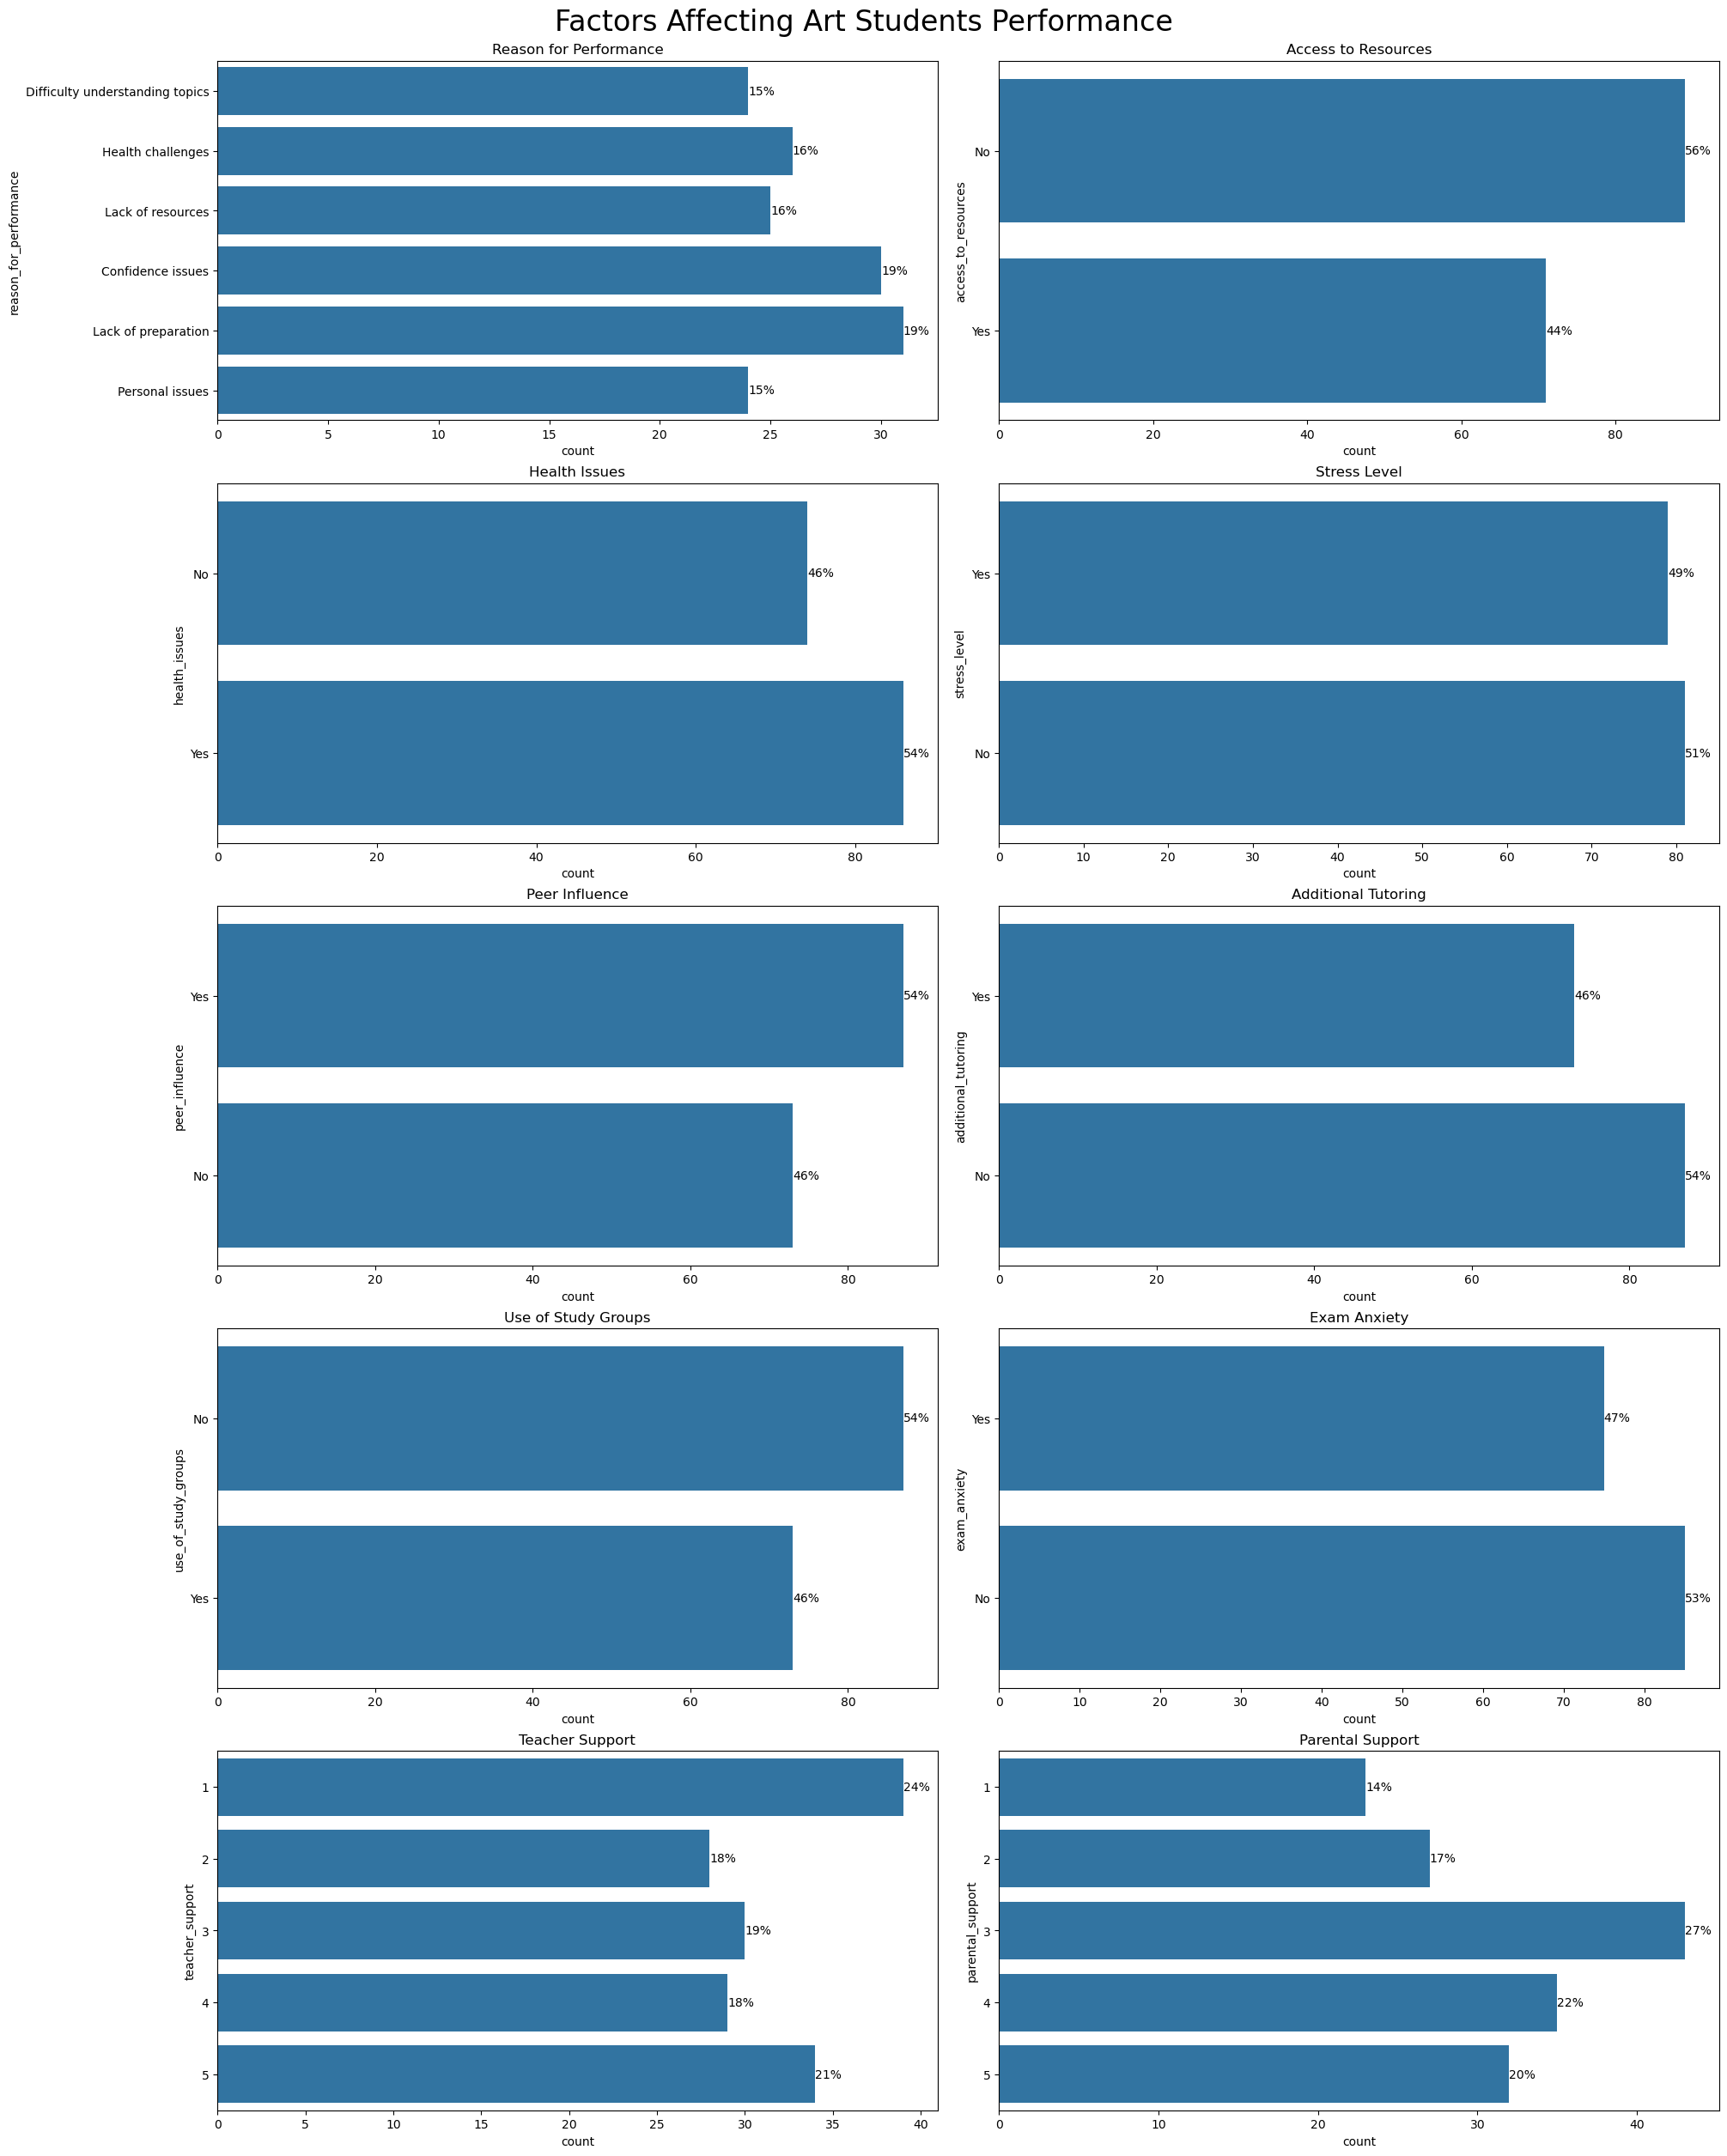

In [26]:
# EDA for factors affecting art students performance
cat_df = art_df[['reason_for_performance', 'access_to_resources', 'health_issues', 'stress_level', 
                  'peer_influence', 'additional_tutoring', 'use_of_study_groups', 'exam_anxiety', 
                  'teacher_support', 'parental_support']]

fig, axs = plt.subplots(5, 2, figsize=(20, 25), layout='constrained')
plt.suptitle('Factors Affecting Art Students Performance', fontsize=24)

# List of titles and corresponding columns
titles = ['Reason for Performance', 'Access to Resources', 'Health Issues', 'Stress Level', 
          'Peer Influence', 'Additional Tutoring', 'Use of Study Groups', 'Exam Anxiety', 
          'Teacher Support', 'Parental Support']

columns = ['reason_for_performance', 'access_to_resources', 'health_issues', 'stress_level', 
           'peer_influence', 'additional_tutoring', 'use_of_study_groups', 'exam_anxiety', 
           'teacher_support', 'parental_support']

# Loop through each subplot
for ax, title, col in zip(axs.flatten(), titles, columns):
    ax.set_title(title)
    sns.countplot(data=cat_df, y=col, ax=ax)

    # Calculate percentages
    total_count = cat_df[col].value_counts()
    for p in ax.patches:
        count = p.get_width()
        percentage = 100 * count / total_count.sum()
        ax.annotate(f'{percentage:.0f}%', (count, p.get_y() + p.get_height() / 2),
                    ha='left', va='center', fontsize=10, color='black')

plt.show()

The charts above show the distribution of how various factors like affect science and arts students.

In [27]:
#descriptive statistics
science_df.describe().T

,count,mean,std,min,25%,50%,75%,max
study_hours_per_week,178.0,20.466292,12.405643,0.0,9.25,20.0,32.00,40.0
teacher_support,178.0,2.994382,1.447762,1.0,2.00,3.0,4.00,5.0
parental_support,178.0,2.893258,1.342424,1.0,2.00,3.0,4.00,5.0
mathematics,178.0,52.308989,28.750633,0.0,28.00,52.0,76.75,100.0
english_language,178.0,50.747191,28.645863,0.0,29.00,48.0,74.50,100.0
civic_education,178.0,48.893258,29.175194,0.0,23.00,47.0,73.00,100.0
economics,178.0,47.578652,30.101467,1.0,20.25,44.5,75.00,100.0
crs_islam,178.0,51.797753,29.111583,0.0,26.00,52.5,78.00,100.0
physics,178.0,54.623596,29.300487,0.0,30.25,55.5,79.00,100.0
chemistry,178.0,49.151685,30.455386,0.0,22.00,49.5,76.00,100.0


In [28]:
#descriptive statistics
art_df.describe().T

,count,mean,std,min,25%,50%,75%,max
study_hours_per_week,160.0,20.96250,11.496178,0.0,10.75,21.0,31.25,40.0
teacher_support,160.0,2.94375,1.480468,1.0,2.00,3.0,4.00,5.0
parental_support,160.0,3.16250,1.321746,1.0,2.00,3.0,4.00,5.0
mathematics,160.0,48.61875,29.751354,0.0,22.00,50.0,73.25,99.0
english_language,160.0,51.28750,30.651703,0.0,22.75,52.0,81.25,99.0
civic_education,160.0,46.13750,28.852365,0.0,22.00,43.0,68.25,100.0
economics,160.0,51.17500,27.669103,1.0,29.00,51.0,71.25,99.0
crs_islam,160.0,51.96875,28.974381,0.0,27.00,55.0,77.25,99.0
government,160.0,51.33125,28.148689,0.0,24.00,57.0,74.00,100.0
commerce,160.0,53.57500,30.437388,0.0,26.75,55.0,80.00,100.0


## Model development


- Predictive model 
- Feature importance

### A) SCIENCE STUDENTS

In [99]:
#splitting data into input and target variables 
X = science_df.drop(['verdict'], axis=1)
y = science_df['verdict']

In [100]:
y

0      Fail
1      Fail
2      Fail
3      Fail
4      Pass
       ... 
327    Fail
328    Pass
332    Pass
333    Fail
335    Pass
Name: verdict, Length: 178, dtype: object

In [101]:
#splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   train_size = 0.75,
                                                   random_state=42)

In [102]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(133, 22) (45, 22)
(133,) (45,)


## Data preprocessing

- Encoding: converting categorical features into a numerical format that can be understood by machine learning algorithms.
- Feature scaling: standardizing the features by transforming these features to a similar scale, ensuring that no single feature dominates the others due to its range.

### Preprocessing on train data

In [103]:
##encoding binary categorical features
binary_mapping = {'Yes': 1, 'No':0}

def binary_encoding(value):
    return 1 if value == 'Yes' else 0

X_train[['access_to_resources', 'health_issues', 'stress_level', 'peer_influence', 'additional_tutoring', 'use_of_study_groups', 'exam_anxiety']] = df[['access_to_resources', 'health_issues', 'stress_level', 'peer_influence', 'additional_tutoring', 'use_of_study_groups', 'exam_anxiety']].applymap(lambda x: binary_mapping.get(x,x))

#one hot encoding the reason_for_performance column
X_train_enc = pd.get_dummies(X_train, columns=['reason_for_performance'], drop_first=True)

#get the names of the new columsn created by pd.get_dummies
new_columns = X_train_enc.columns.difference(X_train.columns)

X_train_enc[new_columns] = X_train_enc[new_columns].astype(int) 

##Feature scaling
train_scaler = StandardScaler()
X_train_scaled = train_scaler.fit_transform(X_train_enc)
X_train_scaled

array([[ 1.05409255, -1.02603406,  1.07012209, ..., -0.44519456,
        -0.38282075, -0.44519456],
       [ 1.05409255, -0.44850219, -0.93447281, ..., -0.44519456,
        -0.38282075, -0.44519456],
       [ 1.05409255, -0.36599764, -0.93447281, ...,  2.24620893,
        -0.38282075, -0.44519456],
       ...,
       [-0.9486833 ,  0.54155244,  1.07012209, ..., -0.44519456,
        -0.38282075, -0.44519456],
       [ 1.05409255, -0.36599764,  1.07012209, ..., -0.44519456,
         2.61218862, -0.44519456],
       [ 1.05409255,  1.28409341,  1.07012209, ..., -0.44519456,
        -0.38282075,  2.24620893]])

In [104]:
X_train_enc

,access_to_resources,study_hours_per_week,health_issues,teacher_support,parental_support,stress_level,peer_influence,additional_tutoring,use_of_study_groups,exam_anxiety,...,chemistry,biology,geography,computer_science,extracurricular_weekly_hours,reason_for_performance_Difficulty understanding topics,reason_for_performance_Health challenges,reason_for_performance_Lack of preparation,reason_for_performance_Lack of resources,reason_for_performance_Personal issues
2,1,8,1,3,2,1,1,0,1,1,...,16.0,73.0,66.0,61.0,8,1,0,0,0,0
189,1,15,0,1,1,0,0,1,1,0,...,73.0,16.0,88.0,95.0,8,1,0,0,0,0
228,1,16,0,1,2,1,0,1,0,0,...,40.0,100.0,91.0,99.0,5,0,0,1,0,0
289,0,40,0,2,4,0,0,0,0,1,...,60.0,58.0,54.0,75.0,6,0,0,0,0,0
90,1,9,0,2,1,0,1,1,1,1,...,77.0,16.0,70.0,58.0,10,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,0,18,1,4,3,1,0,0,0,1,...,39.0,58.0,57.0,3.0,6,0,1,0,0,0
203,1,24,0,1,5,1,1,1,0,1,...,13.0,92.0,3.0,92.0,2,1,0,0,0,0
24,0,27,1,1,3,1,0,0,1,1,...,41.0,5.0,82.0,91.0,10,0,1,0,0,0
172,1,16,1,2,2,0,1,0,1,0,...,22.0,91.0,25.0,49.0,9,0,0,0,1,0


### Preprocessing on test data

In [105]:
binary_mapping = {'Yes': 1, 'No':0}

def binary_encoding(value):
    return 1 if value == 'Yes' else 0

X_test[['access_to_resources', 'health_issues', 'stress_level', 'peer_influence', 'additional_tutoring', 'use_of_study_groups', 'exam_anxiety']] = df[['access_to_resources', 'health_issues', 'stress_level', 'peer_influence', 'additional_tutoring', 'use_of_study_groups', 'exam_anxiety']].applymap(lambda x: binary_mapping.get(x,x))

#one hot encoding the reason_for_performance column
X_test_enc = pd.get_dummies(X_test, columns=['reason_for_performance'], drop_first=True)

#get the names of the new columsn created by pd.get_dummies
new_columns = X_test_enc.columns.difference(X_test.columns)

X_test_enc[new_columns] = X_test_enc[new_columns].astype(int)

#Feature scaling for test data
test_scaler = StandardScaler()
X_test_scaled = test_scaler.fit_transform(X_test_enc)
X_test_scaled

array([[ 1.22474487, -0.88332474, -1.11803399, ..., -0.53452248,
        -0.67202151,  2.15058132],
       [-0.81649658,  1.48636374,  0.89442719, ..., -0.53452248,
         1.48804762, -0.46499055],
       [ 1.22474487, -1.41841568,  0.89442719, ..., -0.53452248,
        -0.67202151, -0.46499055],
       ...,
       [-0.81649658,  1.33348061,  0.89442719, ..., -0.53452248,
         1.48804762, -0.46499055],
       [-0.81649658,  0.03397403,  0.89442719, ..., -0.53452248,
        -0.67202151, -0.46499055],
       [ 1.22474487,  0.87483123, -1.11803399, ..., -0.53452248,
         1.48804762, -0.46499055]])

### Preprocessing on target feature

In [106]:
# Encode y_train and y_test
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_train_encoded

#fail=0, pass = 1

array([0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0])

### Hyper parameter Tuning for model optimization

In [107]:
'''
Defining hyperparameter grids for each model,
that is, the grid contains hyperparameter options for each model in the pipeline
'''

param_grid = {
    'log_reg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'log_reg__C': [0.01, 0.1, 1, 10],
    'log_reg__solver': ['lbfgs', 'liblinear', 'saga'],
    
    'knn__n_neighbors': [3,5,7],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan'],
    
    'dt__criterion': ['gini', 'entropy'],
    'dt__max_depth': [None, 3, 5, 7, 10],
    
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'poly', 'rbf'],
    
    'rf__n_estimators': [100,200],
    'rf__max_depth': [None, 10, 20],
    
    'gb__n_estimators': [50, 100, 150],
    'gb__learning_rate': [0.01, 0.05, 0.1],
    'gb__max_depth': [3,5,7],
    
    'xgb__n_estimators': [100,200],
    'xgb__learning_rate': [0.01, 0.1]
    }

In [108]:
'''
Setting up pipelines for each model. Each model is wrapped in a 
Pipeline allowing chaining preproessing steps and the model itself 
so that they are exectued in sequence
'''

#logistic regression pipeline
log_reg_pipeline = Pipeline([
    ('log_reg', LogisticRegression())
])


#KNN pipeline
knn_pipeline = Pipeline([
    ('knn', KNeighborsClassifier())
])

#decision tree pipeline
dt_pipeline = Pipeline([
    ('dt', DecisionTreeClassifier())
])

#svc pipeline
svc_pipeline = Pipeline([
    ('svc', SVC())
])

#random forest pipeline
rf_pipeline = Pipeline([
    ('rf', RandomForestClassifier())
])


#gradient boosting pipeline
gb_pipeline = Pipeline([
    ('gb', GradientBoostingClassifier())
])

xgb_pipeline = Pipeline([
    ('xgb', XGBClassifier(use_label_encoder=False)) ##check this
])


In [109]:
'''
GridSearchCV is used to find the best hyperparameters for each 
pipeline through a grid search
'''

##combine pipelines into a single grid search

#define a dictionary for all pipelines
pipelines = {
    'log_reg': log_reg_pipeline,
    'knn': knn_pipeline,
    'dt': dt_pipeline,
    'svc': svc_pipeline,
    'rf': rf_pipeline,
    'gb': gb_pipeline,
    'xgb': xgb_pipeline
}


grid_searches = {}
for name, pipeline in pipelines.items():
    print(f"Running GridSearch for {name}...")
    
    grid_search = GridSearchCV(pipeline,
                              {key: value for key, value in param_grid.items() if key.startswith(name)},
                              cv = 5,
                              n_jobs = -1,
                              verbose = 1)
    
    grid_search.fit(X_train_scaled, y_train_encoded)
    grid_searches[name] = grid_search

Running GridSearch for log_reg...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Running GridSearch for knn...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Running GridSearch for dt...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Running GridSearch for svc...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Running GridSearch for rf...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Running GridSearch for gb...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Running GridSearch for xgb...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [110]:
#accessing the best parameters for each model

for name, grid_search in grid_searches.items():
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best score for {name}: {grid_search.best_score_}")

Best parameters for log_reg: {'log_reg__C': 0.01, 'log_reg__penalty': 'l1', 'log_reg__solver': 'liblinear'}
Best score for log_reg: 0.594017094017094
Best parameters for knn: {'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}
Best score for knn: 0.5552706552706553
Best parameters for dt: {'dt__criterion': 'entropy', 'dt__max_depth': 3}
Best score for dt: 0.6014245014245014
Best parameters for svc: {'svc__C': 1, 'svc__kernel': 'poly'}
Best score for svc: 0.6085470085470085
Best parameters for rf: {'rf__max_depth': None, 'rf__n_estimators': 200}
Best score for rf: 0.5706552706552707
Best parameters for gb: {'gb__learning_rate': 0.05, 'gb__max_depth': 3, 'gb__n_estimators': 50}
Best score for gb: 0.6535612535612536
Best parameters for xgb: {'xgb__learning_rate': 0.01, 'xgb__n_estimators': 200}
Best score for xgb: 0.5413105413105412


In [111]:
##retriveing the models built with the best hyperparameters
best_log_reg = grid_searches['log_reg'].best_estimator_
best_knn = grid_searches['knn'].best_estimator_
best_dt = grid_searches['dt'].best_estimator_
best_svc = grid_searches['svc'].best_estimator_
best_rf = grid_searches['rf'].best_estimator_
best_gb = grid_searches['gb'].best_estimator_
best_xgb = grid_searches['xgb'].best_estimator_

### Feature importance

In [112]:
X_train_enc.shape

(133, 26)

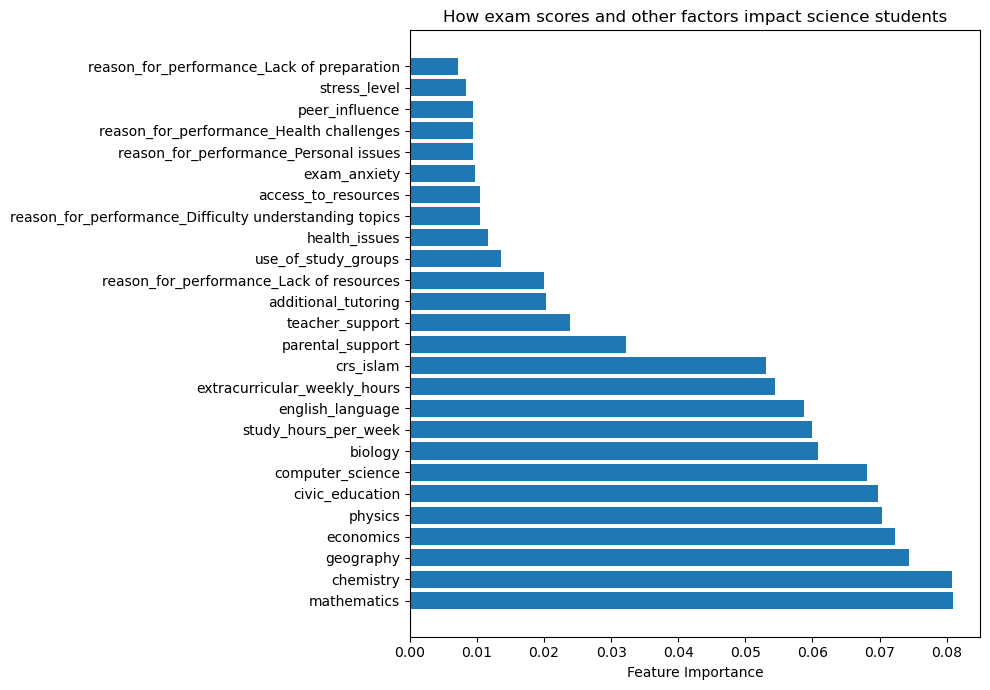

In [114]:
feature_importances = best_rf.named_steps['rf'].feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 7))
plt.title("How exam scores and other factors impact science students")
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), X_train_enc.columns[indices])
plt.xlabel("Feature Importance")
plt.tight_layout()

In the Nigerian educational system, a student is usually considered for admission if he/she has at least 5 credit passes for relevant subjects in the WASSCE exams and a JAMB score that meets the cut off mark (usually based on the school and the course of study). 

From the plot above, asides from the 10 subjects that play a role in determining the pass/fail of a student, there were 5 other factors that impacted students performance:

1. **Number of study hours per week**: this speaks to whether or not the students had enough number of hours to study per week. Were they other activities taking up this study time? EDA shows that the average number of hours spent per week by science students is 19.6 hours. Further analysis can reveal if this number of hours is enough or if increasing the number of study hours would improve student performance.





2. **Extracurricular hours per week**: at GMS, extracurricular activities are compulsory. Does the number of hours spent in weekly extracurriculars positively or negatively impact the students perormance? Would making extracurriculars optional improve the student's chances of performing better academically? Are the students unhappy with these extracurriculars being forced down their throats? From our EDA, we noticed that science students spend between 1 - 10 hours weekly on extracurricular activities like sports or being part of the Jet club, debate club, drama club, etc.





3. **Teacher Support**: EDA revealed that 22% of the science students felt less support from the teachers while 23% felt the teachers provided enough support for them in class through availability of these teachers to provide clarifications both within and outside the classroom.





4. **Parental support**: A similar case applies here where 48% of the students stated an average level of support from parents. Where parental support includes:
    - Parental supervision of students school work and grades
    - Parental overall attitude towards education and atmosphere at home (peaceful/quarrelsome, accomodating/tight-fisted).
    
To this point, a research done by `Uzochukwu and Uchechukwu (2023)` (refer to the references section) shows that unhealthy parenting wheels tremendous negative influence on the schooling of secondary school students



5. **Lack of resources & additional tutoring**: Again, EDA showed that 17% of the science students at GMS noted a lack of necessary resources like textbooks, study guides, practical lessons, etc as a reason for their performance. It is known that study and practice makes perfect but what happens when adequate resources/avenues are unavialable for students to learn from? Also, asides from class teachings, are the students enrolled in extra lessons? 51% of the students reported not being enrolled in any additional lessons or tutoring.


The questions been posed here are experiements the management at GMS can carry out, collect data from and analyze whether there was a change in academic performance. 

At the end of the day, it does matter if a student is happy at school because according to the `European Online Journal of Natural and Social Sciences`, there is “a significant positive relationship between happiness and achievement of students.” The authors `(Tabbodi, Rahgozar, Mozaffari and Abadi, 2015)` of the study also found a significant correlation “between happiness and  the progress of students… an increase or decrease in happiness increases or decreases the level  of academic achievement.”

In [115]:
#model retraining with these 16 features

X_train_enc = X_train_enc[['chemistry', 'physics', 'mathematics', 'economics', 'english_language', 'geography', 'civic_education', 'biology', 'crs_islam', 'computer_science', 'extracurricular_weekly_hours', 'study_hours_per_week', 'parental_support', 'teacher_support', 'additional_tutoring', 'reason_for_performance_Lack of resources']]
X_test_enc = X_test_enc[['chemistry', 'physics', 'mathematics', 'economics', 'english_language', 'geography', 'civic_education', 'biology', 'crs_islam', 'computer_science', 'extracurricular_weekly_hours', 'study_hours_per_week', 'parental_support', 'teacher_support', 'additional_tutoring', 'reason_for_performance_Lack of resources']]

#Feature scaling
X_train_scaled = train_scaler.fit_transform(X_train_enc)
X_test_scaled = test_scaler.fit_transform(X_test_enc)


#dictionary for all pipelines
pipelines = {
    'log_reg': log_reg_pipeline,
    'knn': knn_pipeline,
    'dt': dt_pipeline,
    'svc': svc_pipeline,
    'rf': rf_pipeline,
    'gb': gb_pipeline,
    'xgb': xgb_pipeline
}


grid_searches = {}
for name, pipeline in pipelines.items():
    #print(f"Running GridSearch for {name}...")
    
    grid_search = GridSearchCV(pipeline,
                              {key: value for key, value in param_grid.items() if key.startswith(name)},
                              cv = 5,
                              n_jobs = -1,
                              verbose = 1)
    
    grid_search.fit(X_train_scaled, y_train_encoded)
    grid_searches[name] = grid_search

#accessing the best parameters for each model

for name, grid_search in grid_searches.items():
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best score for {name}: {grid_search.best_score_}")
    
##retriveing the models built with the best hyperparameters
best_log_reg = grid_searches['log_reg'].best_estimator_
best_knn = grid_searches['knn'].best_estimator_
best_dt = grid_searches['dt'].best_estimator_
best_svc = grid_searches['svc'].best_estimator_
best_rf = grid_searches['rf'].best_estimator_
best_gb = grid_searches['gb'].best_estimator_
best_xgb = grid_searches['xgb'].best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for log_reg: {'log_reg__C': 0.01, 'log_reg__penalty': 'l2', 'log_reg__solver': 'lbfgs'}
Best score for log_reg: 0.6011396011396011
Best parameters for knn: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'uniform'}
Best score for knn: 0.5393162393162394
Best parameters for dt: {'dt__criterion': 'entropy', 'dt__max_depth': 3}
Best score for dt: 0.6014245014245014
Best parameters for svc: {'svc__C': 1, 'svc__kernel': 'poly'}
Best score for svc: 0.6082621082621082
Best parameters for rf: {'rf__max_depth': None, 'rf__n_estimators': 100}

In [116]:
#calculating train scores
train_scores = {
    'Logistic Regression': best_log_reg.score(X_train_scaled, y_train_encoded),
    'KNN': best_knn.score(X_train_scaled, y_train_encoded),
    'Decision Tree': best_dt.score(X_train_scaled, y_train_encoded),
    'SVC': best_svc.score(X_train_scaled, y_train_encoded),
    'Random Forest': best_rf.score(X_train_scaled, y_train_encoded),
    'Gradient Boosting': best_gb.score(X_train_scaled, y_train_encoded),
    'XGB': best_xgb.score(X_train_scaled, y_train_encoded)

}

#calculating test scores
test_scores = {
    'Logistic Regression': best_log_reg.score(X_test_scaled, y_test_encoded),
    'KNN': best_knn.score(X_test_scaled, y_test_encoded),
    'Decision Tree': best_dt.score(X_test_scaled, y_test_encoded),
    'SVC': best_svc.score(X_test_scaled, y_test_encoded),
    'Random Forest': best_rf.score(X_test_scaled, y_test_encoded),
    'Gradient Boosting': best_gb.score(X_test_scaled, y_test_encoded),
    'XGB': best_xgb.score(X_test_scaled, y_test_encoded)

}

scores_df = pd.DataFrame({
    'Train score': train_scores,
    'Test score': test_scores
})

scores_df

,Train score,Test score
Logistic Regression,0.616541,0.466667
KNN,0.631579,0.488889
Decision Tree,0.676692,0.533333
SVC,0.827068,0.488889
Random Forest,1.000000,0.511111
Gradient Boosting,0.849624,0.511111
XGB,0.984962,0.444444


This shows a case of overfitting in the data where the data learns a lot from the training phase but lacks adequate generalizability. Below, we explored further methods to improve generalizability.

In [117]:
## creating a voting classifier

voting_clf = VotingClassifier(estimators=[
    ('log_reg', best_log_reg),
    ('dt', best_dt),
    ('rf', best_rf)
], voting='hard')

voting_clf.fit(X_train_scaled, y_train)

train_score = voting_clf.score(X_train_scaled, y_train)
test_score = voting_clf.score(X_test_scaled, y_test)
print(f"Train score for Voting Classifier: {train_score:.4f}")
print(f"Test score for Voting Classifier: {test_score:.4f}")

Train score for Voting Classifier: 0.9699
Test score for Voting Classifier: 0.5111


In [118]:
#using a stacking classifier

estimators = [
    ('LR', best_log_reg),
    ('dt', best_dt),
    ('rf', best_rf)]

stack_classifier = StackingClassifier(estimators=estimators,
                                     final_estimator=best_log_reg)

stack_classifier.fit(X_train_scaled, y_train)

rain_score = stack_classifier.score(X_train_scaled, y_train)
test_score = stack_classifier.score(X_test_scaled, y_test)
print(f"Train score for Stacking Classifier: {train_score:.2f}")
print(f"Test score for Stacking Classifier: {test_score:.2f}")

Train score for Stacking Classifier: 0.97
Test score for Stacking Classifier: 0.47


After several trials and processes including dimensionality reduction and feature selection the models still overfit. This is attributed to the fact that even though the data represents the Nigerian educational ecosystem, it is still a generated data and does not adequately reflect real-life data. Due to this limitation, our choice of model would be based on the confusion matrix distribution. 

**Please note that upon implementation of this solution to real-world scenario and data, the overfitting issue can easily be resolved.**

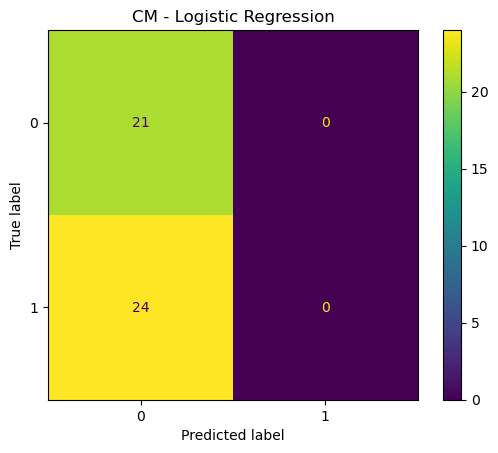

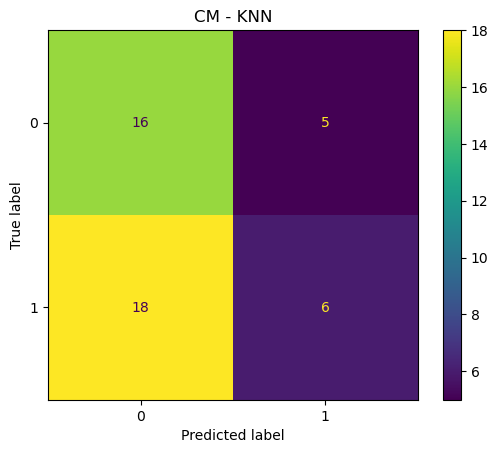

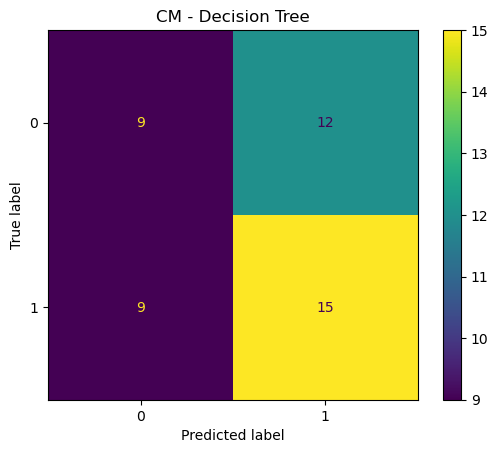

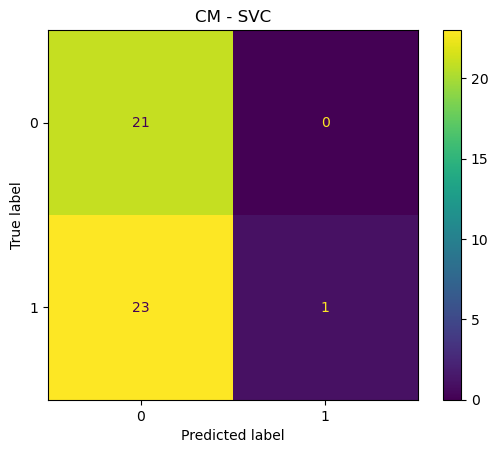

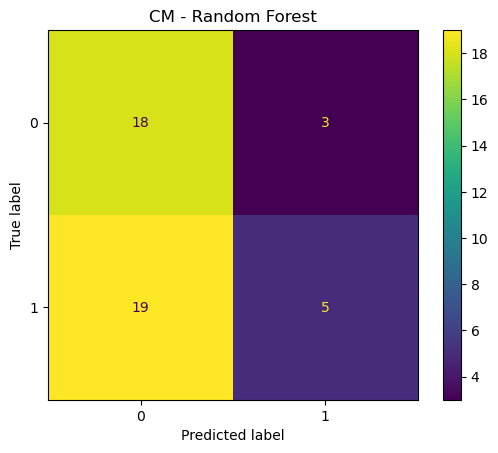

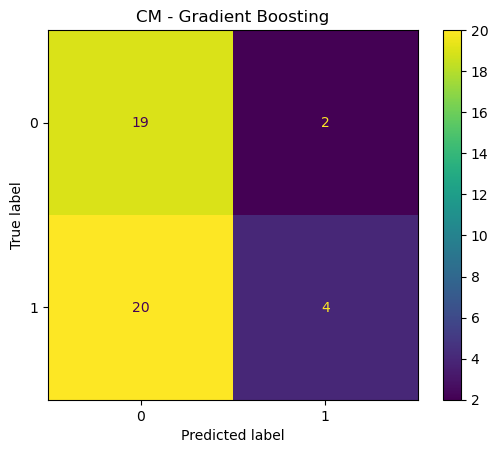

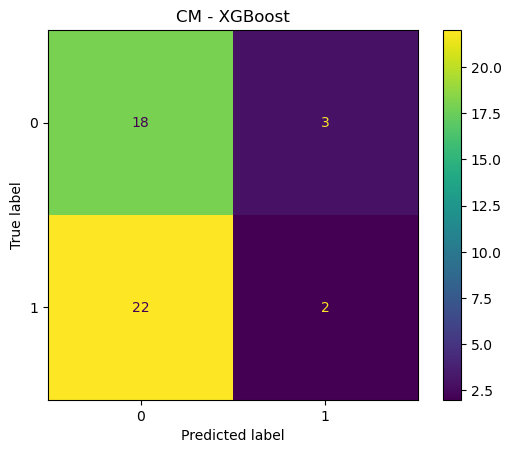

In [119]:
#using confusion matrix (CM)
models = [best_log_reg, best_knn, best_dt, best_svc, best_rf, best_gb, best_xgb]
model_names = ['Logistic Regression', 'KNN', 'Decision Tree', 'SVC', 'Random Forest', 'Gradient Boosting', 'XGBoost']
    
for model, name in zip(models, model_names):
    # Generate predictions
    y_pred = model.predict(X_test_scaled)
    
    # Create the confusion matrix plot
    ConfusionMatrixDisplay.from_predictions(y_test_encoded, y_pred, values_format='d')
    
    # Set the title to the model name
    plt.title(f"CM - {name}")
    
    # Display the plot
    plt.show()

After careful observation, the **Decision tree model** is our predictive model of choice for the science students. This is evident in the model's ability to more correctly predict pass and failure cases compared to other models. 

In [120]:
#saving the best model

joblib.dump(best_dt, 'DT_model_sci.pkl')

['DT_model_sci.pkl']

### B) ART STUDENTS

In [121]:
X = art_df.drop(['verdict'], axis=1)
y = art_df['verdict']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   train_size = 0.75,
                                                   random_state=42)

In [122]:
##preprocessing train data
binary_mapping = {'Yes': 1, 'No':0}

def binary_encoding(value):
    return 1 if value == 'Yes' else 0

X_train[['access_to_resources', 'health_issues', 'stress_level', 'peer_influence', 'additional_tutoring', 'use_of_study_groups', 'exam_anxiety']] = df[['access_to_resources', 'health_issues', 'stress_level', 'peer_influence', 'additional_tutoring', 'use_of_study_groups', 'exam_anxiety']].applymap(lambda x: binary_mapping.get(x,x))

#one hot encoding the reason_for_performance column
X_train_enc = pd.get_dummies(X_train, columns=['reason_for_performance'], drop_first=True)

#get the names of the new columsn created by pd.get_dummies
new_columns = X_train_enc.columns.difference(X_train.columns)

X_train_enc[new_columns] = X_train_enc[new_columns].astype(int) 

##Feature scaling
train_scaler = StandardScaler()
X_train_scaled = train_scaler.fit_transform(X_train_enc)


##preprocessing test data
binary_mapping = {'Yes': 1, 'No':0}

def binary_encoding(value):
    return 1 if value == 'Yes' else 0

X_test[['access_to_resources', 'health_issues', 'stress_level', 'peer_influence', 'additional_tutoring', 'use_of_study_groups', 'exam_anxiety']] = df[['access_to_resources', 'health_issues', 'stress_level', 'peer_influence', 'additional_tutoring', 'use_of_study_groups', 'exam_anxiety']].applymap(lambda x: binary_mapping.get(x,x))

#one hot encoding the reason_for_performance column
X_test_enc = pd.get_dummies(X_test, columns=['reason_for_performance'], drop_first=True)

#get the names of the new columsn created by pd.get_dummies
new_columns = X_test_enc.columns.difference(X_test.columns)

X_test_enc[new_columns] = X_test_enc[new_columns].astype(int)

#Feature scaling for test data
test_scaler = StandardScaler()
X_test_scaled = test_scaler.fit_transform(X_test_enc)


#Preprocessing on target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [123]:
##HYPER PARAMETER TUNING
param_grid = {
    'log_reg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'log_reg__C': [0.01, 0.1, 1, 10],
    'log_reg__solver': ['lbfgs', 'liblinear', 'saga'],
    
    'knn__n_neighbors': [3,5,7],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan'],
    
    'dt__criterion': ['gini', 'entropy'],
    'dt__max_depth': [None, 3, 5, 7, 10],
    
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'poly', 'rbf'],
    
    'rf__n_estimators': [100,200],
    'rf__max_depth': [None, 10, 20],
    
    'gb__n_estimators': [50, 100, 150],
    'gb__learning_rate': [0.01, 0.05, 0.1],
    'gb__max_depth': [3,5,7],
    
    'xgb__n_estimators': [100,200],
    'xgb__learning_rate': [0.01, 0.1]
    }

#logistic regression pipeline
log_reg_pipeline = Pipeline([
    ('log_reg', LogisticRegression())
])


#KNN pipeline
knn_pipeline = Pipeline([
    ('knn', KNeighborsClassifier())
])

#decision tree pipeline
dt_pipeline = Pipeline([
    ('dt', DecisionTreeClassifier())
])

#svc pipeline
svc_pipeline = Pipeline([
    ('svc', SVC())
])

#random forest pipeline
rf_pipeline = Pipeline([
    ('rf', RandomForestClassifier())
])


#gradient boosting pipeline
gb_pipeline = Pipeline([
    ('gb', GradientBoostingClassifier())
])

xgb_pipeline = Pipeline([
    ('xgb', XGBClassifier(use_label_encoder=False)) ##check this
])


##combine pipelines into a single grid search

#define a dictionary for all pipelines
pipelines = {
    'log_reg': log_reg_pipeline,
    'knn': knn_pipeline,
    'dt': dt_pipeline,
    'svc': svc_pipeline,
    'rf': rf_pipeline,
    'gb': gb_pipeline,
    'xgb': xgb_pipeline
}


grid_searches = {}
for name, pipeline in pipelines.items():
    print(f"Running GridSearch for {name}...")
    
    grid_search = GridSearchCV(pipeline,
                              {key: value for key, value in param_grid.items() if key.startswith(name)},
                              cv = 5,
                              n_jobs = -1,
                              verbose = 1)
    
    grid_search.fit(X_train_scaled, y_train_encoded)
    grid_searches[name] = grid_search

Running GridSearch for log_reg...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Running GridSearch for knn...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Running GridSearch for dt...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Running GridSearch for svc...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Running GridSearch for rf...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Running GridSearch for gb...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Running GridSearch for xgb...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [124]:
#accessing the best parameters for each model

for name, grid_search in grid_searches.items():
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best score for {name}: {grid_search.best_score_}")

Best parameters for log_reg: {'log_reg__C': 0.1, 'log_reg__penalty': 'l1', 'log_reg__solver': 'saga'}
Best score for log_reg: 0.5583333333333333
Best parameters for knn: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'uniform'}
Best score for knn: 0.5916666666666667
Best parameters for dt: {'dt__criterion': 'entropy', 'dt__max_depth': 7}
Best score for dt: 0.65
Best parameters for svc: {'svc__C': 1, 'svc__kernel': 'rbf'}
Best score for svc: 0.5666666666666667
Best parameters for rf: {'rf__max_depth': 20, 'rf__n_estimators': 100}
Best score for rf: 0.5499999999999999
Best parameters for gb: {'gb__learning_rate': 0.1, 'gb__max_depth': 7, 'gb__n_estimators': 100}
Best score for gb: 0.6166666666666667
Best parameters for xgb: {'xgb__learning_rate': 0.01, 'xgb__n_estimators': 200}
Best score for xgb: 0.55


In [125]:
##retriveing the models built with the best hyperparameters
best_log_reg = grid_searches['log_reg'].best_estimator_
best_knn = grid_searches['knn'].best_estimator_
best_dt = grid_searches['dt'].best_estimator_
best_svc = grid_searches['svc'].best_estimator_
best_rf = grid_searches['rf'].best_estimator_
best_gb = grid_searches['gb'].best_estimator_
best_xgb = grid_searches['xgb'].best_estimator_

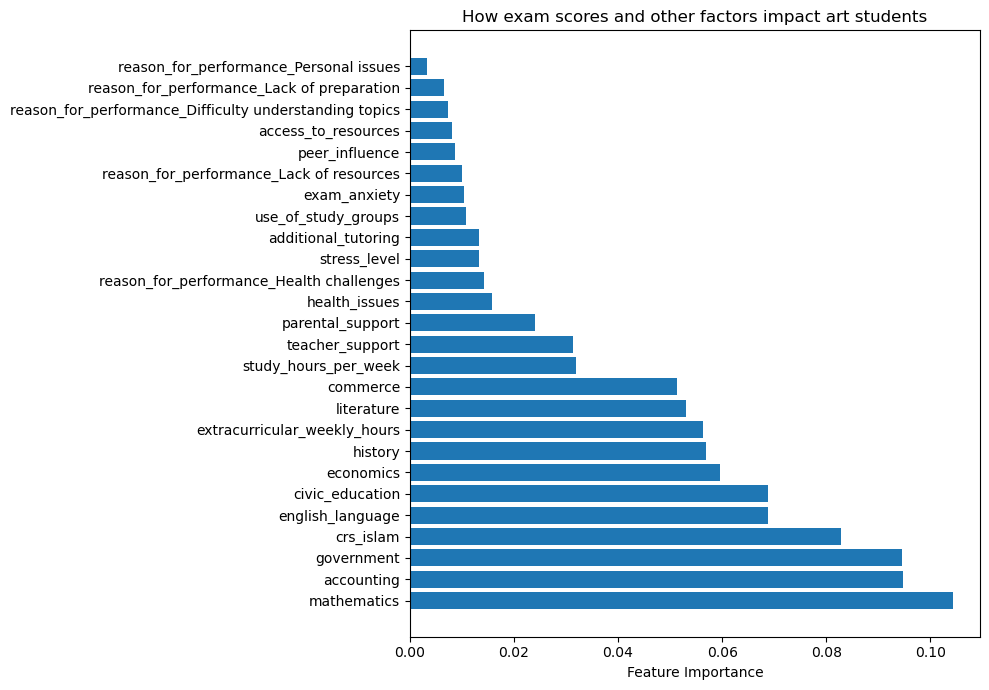

In [126]:
##feature importance

feature_importances = best_rf.named_steps['rf'].feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 7))
plt.title("How exam scores and other factors impact art students")
plt.barh(range(X_train_scaled.shape[1]), feature_importances[indices], align='center')
plt.yticks(range(X_train_scaled.shape[1]), X_train_enc.columns[indices])
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

Similar to science students, art students would need to meet a university school's criteria before gaining admission. 

Again, asides the subjects being offered other factors included:

- Study hours per week
- Extracurricular hours
- Teacher support 
- Parental support
- Health issues

The same reasoning as for science students also applies for art students since they share similar characteristics or factors that affects their overall performance. The exception here is that 54% of art students (according to EDA) noted that their academic performance was due to health challenges they experienced. 

In [127]:
#model retraining with these 16 features

X_train_enc = X_train_enc[['accounting', 'government', 'mathematics', 'economics', 'english_language', 'history', 'civic_education', 'commerce', 'crs_islam', 'literature', 'extracurricular_weekly_hours', 'study_hours_per_week', 'parental_support', 'teacher_support', 'health_issues']]
X_test_enc = X_test_enc[['accounting', 'government', 'mathematics', 'economics', 'english_language', 'history', 'civic_education', 'commerce', 'crs_islam', 'literature', 'extracurricular_weekly_hours', 'study_hours_per_week', 'parental_support', 'teacher_support', 'health_issues']]

#Feature scaling
X_train_scaled = train_scaler.fit_transform(X_train_enc)
X_test_scaled = test_scaler.fit_transform(X_test_enc)


#dictionary for all pipelines
pipelines = {
    'log_reg': log_reg_pipeline,
    'knn': knn_pipeline,
    'dt': dt_pipeline,
    'svc': svc_pipeline,
    'rf': rf_pipeline,
    'gb': gb_pipeline,
    'xgb': xgb_pipeline
}


grid_searches = {}
for name, pipeline in pipelines.items():
    #print(f"Running GridSearch for {name}...")
    
    grid_search = GridSearchCV(pipeline,
                              {key: value for key, value in param_grid.items() if key.startswith(name)},
                              cv = 5,
                              n_jobs = -1,
                              verbose = 1)
    
    grid_search.fit(X_train_scaled, y_train_encoded)
    grid_searches[name] = grid_search

#accessing the best parameters for each model

for name, grid_search in grid_searches.items():
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best score for {name}: {grid_search.best_score_}")
    
##retriveing the models built with the best hyperparameters
best_log_reg = grid_searches['log_reg'].best_estimator_
best_knn = grid_searches['knn'].best_estimator_
best_dt = grid_searches['dt'].best_estimator_
best_svc = grid_searches['svc'].best_estimator_
best_rf = grid_searches['rf'].best_estimator_
best_gb = grid_searches['gb'].best_estimator_
best_xgb = grid_searches['xgb'].best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for log_reg: {'log_reg__C': 0.01, 'log_reg__penalty': 'l2', 'log_reg__solver': 'lbfgs'}
Best score for log_reg: 0.6083333333333333
Best parameters for knn: {'knn__metric': 'euclidean', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
Best score for knn: 0.6416666666666667
Best parameters for dt: {'dt__criterion': 'entropy', 'dt__max_depth': 7}
Best score for dt: 0.65
Best parameters for svc: {'svc__C': 10, 'svc__kernel': 'poly'}
Best score for svc: 0.6333333333333334
Best parameters for rf: {'rf__max_depth': 20, 'rf__n_estimators': 200}
Best score for

In [128]:
#calculating train scores
train_scores = {
    'Logistic Regression': best_log_reg.score(X_train_scaled, y_train_encoded),
    'KNN': best_knn.score(X_train_scaled, y_train_encoded),
    'Decision Tree': best_dt.score(X_train_scaled, y_train_encoded),
    'SVC': best_svc.score(X_train_scaled, y_train_encoded),
    'Random Forest': best_rf.score(X_train_scaled, y_train_encoded),
    'Gradient Boosting': best_gb.score(X_train_scaled, y_train_encoded),
    'XGB': best_xgb.score(X_train_scaled, y_train_encoded)

}

#calculating test scores
test_scores = {
    'Logistic Regression': best_log_reg.score(X_test_scaled, y_test_encoded),
    'KNN': best_knn.score(X_test_scaled, y_test_encoded),
    'Decision Tree': best_dt.score(X_test_scaled, y_test_encoded),
    'SVC': best_svc.score(X_test_scaled, y_test_encoded),
    'Random Forest': best_rf.score(X_test_scaled, y_test_encoded),
    'Gradient Boosting': best_gb.score(X_test_scaled, y_test_encoded),
    'XGB': best_xgb.score(X_test_scaled, y_test_encoded)

}

scores_df = pd.DataFrame({
    'Train score': train_scores,
    'Test score': test_scores
})

scores_df

,Train score,Test score
Logistic Regression,0.691667,0.675
KNN,0.816667,0.525
Decision Tree,0.991667,0.600
SVC,1.000000,0.600
Random Forest,1.000000,0.600
Gradient Boosting,1.000000,0.575
XGB,1.000000,0.550


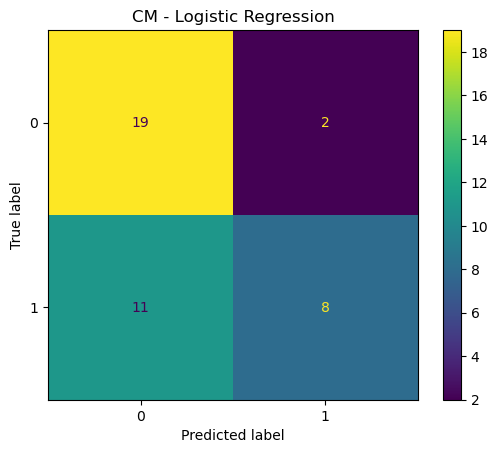

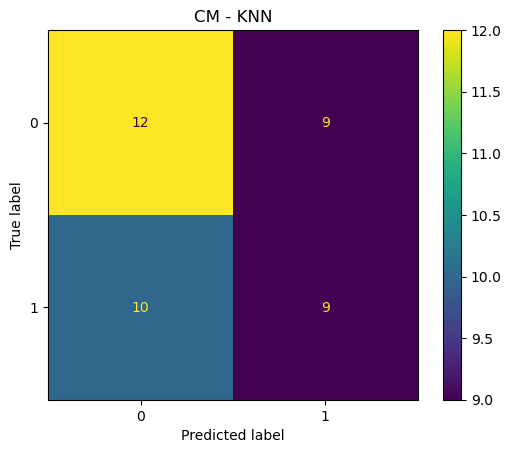

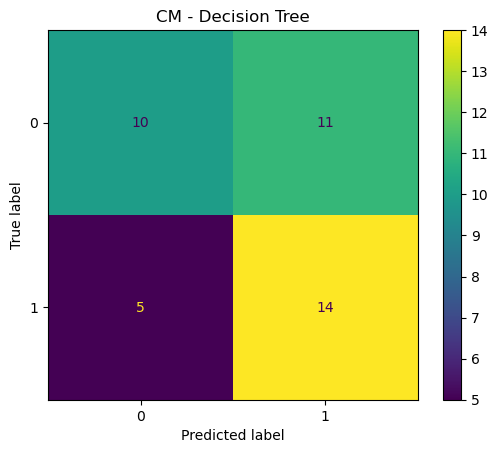

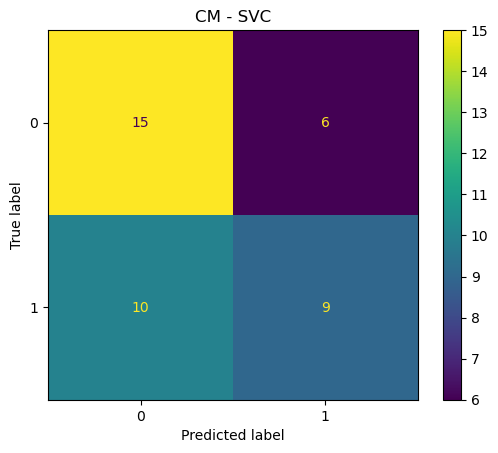

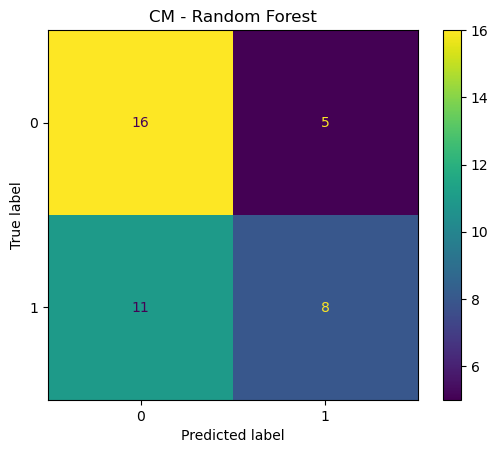

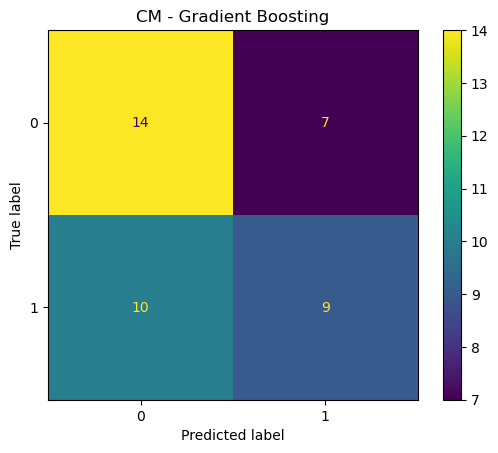

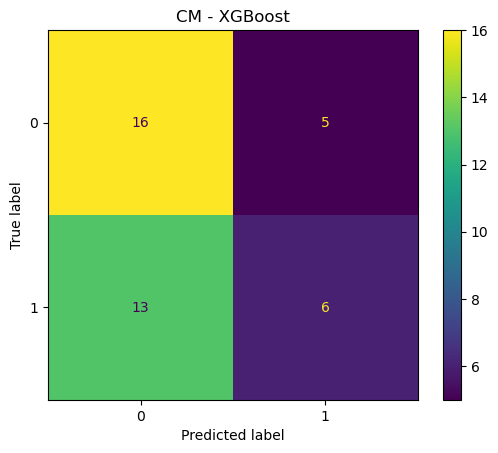

In [129]:
models = [best_log_reg, best_knn, best_dt, best_svc, best_rf, best_gb, best_xgb]
model_names = ['Logistic Regression', 'KNN', 'Decision Tree', 'SVC', 'Random Forest', 'Gradient Boosting', 'XGBoost']

for model, name in zip(models, model_names):
    # Generate predictions
    y_pred = model.predict(X_test_scaled)
    
    # Create the confusion matrix plot
    ConfusionMatrixDisplay.from_predictions(y_test_encoded, y_pred, values_format='d')
    
    # Set the title to the model name
    plt.title(f"CM - {name}")
    
    # Display the plot
    plt.show()

Just like with the science students, for the art students, our model decision is based on ability of the model to more correctly predict pass and failure cases when compared to other models. The model of choice here is **Logistic regression.**

In [130]:
#saving the best model

joblib.dump(best_log_reg, 'LR_model_art.pkl')

['LR_model_art.pkl']